In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gudhi as gd
from torch.autograd import Variable
import networkx as nx
import scipy.sparse
from nn_homology import nn_graph
import dionysus as d

torch.manual_seed(2)

In [2]:
G = nx.DiGraph()
G.add_edge(0,1,weight=2)
G.add_edge(1,2,weight=1)
G.add_edge(2,3,weight=4)
G.add_edge(3,4,weight=5)
G.add_edge(4,1,weight=5)

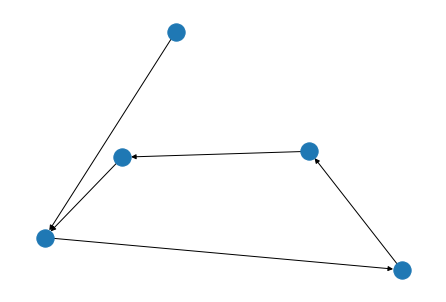

In [3]:
nx.draw_spring(G)

In [4]:
from collections import defaultdict

# Returns enhanced diagram from a filtration
# dgm - a dictionary indexed by dimension
# Note:
#    if death time is infinite - then the second pairing is meaningless
#     each dictionarry is a list of 4-tuples
#        (birth time, death time, birth vertex, death vertex)
# Input: m is the output of homology_persistence(f),
#        f is a filtration
#        Tbl is a dictionary from simplex to vertex (depends on the function)
def returndgm(m,f,Tbl):
    dgm = {}
    for i in range(len(m)-1):
        dgm[i] = []
    # Tbl is a dictionary from simplex to vertex (depends on the function) / from simplex to two points (three points cause includes value)
    # b_value_i, d_value_i, b_e_b (or -1), b_e_d (or -1), d_e_b (or -1), d_e_d (or -1)
    #point_index_to_points_indices = defaultdict(lambda: [])
    for i in range(len(m)-1):
        if m.pair(i) < i: continue      # skip negative simplices
        dim = int(f[i].dimension())
        pair = m.pair(i) # now an edge
        if pair != m.unpaired and f[pair].data-f[i].data > 0:
            b_a, d_a = Tbl[i], Tbl[pair] # FROM TABLE!
            dgm[dim].append( [f[i].data, f[pair].data, b_a[0], b_a[1], d_a[0], d_a[1]] )
        elif m.pair(i) == m.unpaired:
            b_a = Tbl[i]
            dgm[dim].append([f[i].data, np.inf, b_a[0], b_a[1], -1, -1])
    return dgm #, point_index_to_points_indices

# currently the fastest update procedure
# takes in a filtration F and a vector fnew of new
# function values defined on the vertices
# TODO: check if we update Tbl is it faster
#       than creating it from scratch each time
''' OBS: Don't think it's working for homology classes of dimension 2 '''
def computePersistence(F):
    # update filtration
    # TODO: F and fnew doesn't have to have the same number of decimals!!!!!
    Tbl = {} # From simplex to attaching edge [a,b,value]
    #round_decimals = 10
    # SETTING IT TO s.data changes the float, must be somthing with the filtration structure
    F.sort() # so we know we are visting lover dimension before higher dimensions
    for s in F:
        index_s = F.index(s)
        if s.dimension() == 0:
            Tbl[index_s] = [-1, -1, 0]
        elif s.dimension() == 1:
            max_edge = [s[0], s[1], s.data]
            Tbl[index_s] = max_edge
        elif s.dimension() == 2: # s is now a triangle
            edges = [F.index(b) for b in s.boundary()]
            edges_data = [F[e].data for e in edges]
            edge_index = np.argmax(np.array([edges_data]))
            attaching = [F[edges[edge_index]][0], F[edges[edge_index]][1], edges_data[edge_index]]
            Tbl[index_s] = attaching
        elif s.dimension() == 3: # s is now a tetrahedron
            edges_triples = [Tbl[F.index(b)] for b in s.boundary()]
            edges_data = [e[2] for e in edges_triples]
            edge_index = np.argmax(np.array([edges_data]))
            attaching = edges_triples[edge_index]
            Tbl[index_s] = attaching
        else:
            print("WARNING-topologicalutils: something is wrong. Too high dimensional")
            assert(False)

    m = d.homology_persistence(F) # compute persistence
    dgms = returndgm(m,F,Tbl) # compute diagrams
    return dgms, Tbl  # return

In [5]:
def to_dionysus_filtration(G, maxdim=2):
    adj = nx.to_adjacency_matrix(G).todense()
    return d.fill_rips(adj, maxdim, 10)

def graph_filtration_rips(model, param_info, input_size, maxdim=2):
    weights = nn_graph.get_weights(model)
    params = nn_graph.append_params(param_info, weights)
    
    G = nn_graph.to_directed_networkx(params, input_size)
    return to_dionysus_filtration(G, maxdim=maxdim)

In [6]:
dtype=torch.float32
class Diagramlayer(torch.autograd.Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, model, param_info, input_size, maxdim=1, verbose=False):
        SKELETON_DIMENSION = maxdim + 1 # maximal simplex dimension
        if verbose: print("*** dgm start")

        start_time = time.time()
        F = graph_filtration_rips(model, param_info, input_size, maxdim=SKELETON_DIMENSION)

        dgms, Tbl = computePersistence(F)
        max_pts = np.max([len(dgms[i]) for i in range(maxdim+1)])
        num_dgm_pts = max_pts
        ''' -1 is used later '''
        dgms_inds = -1 * np.ones([maxdim+1, num_dgm_pts, 4])
        dgms_values = -np.inf * np.ones([maxdim+1, num_dgm_pts, 2]) # -1.0 * np.ones([3, num_dgm_pts, 2])
        for dim in range(maxdim+1):
            if len(dgms[dim]) > 0:
                dgm = np.array(dgms[dim])
                l = np.min([num_dgm_pts, len(dgm)])
                arg_sort = np.argsort(np.abs(dgm[:,1] - dgm[:,0]))[::-1]
                dgms_inds[dim][:l] = dgm[arg_sort[:l], 2:6]
                dgms_values[dim][:l] = dgm[arg_sort[:l], 0:2]

        dgms_inds = dgms_inds.reshape([maxdim+1, num_dgm_pts, 2, 2])
        #print dgms_values
        #dgms_values[dgms_values == np.inf] = SATURATION_VALUE #-1.0, Won't show up as inifinite, but good enough
        output = torch.tensor(dgms_values).type(dtype)
        ctx.save_for_backward(x, torch.tensor(dgms_inds).type(dtype), output, torch.tensor(verbose))
        if verbose: print("*** dgm done", time.time() - start_time)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):

        input, dgms_inds, dgms_values, verbose = ctx.saved_variables
        if verbose: print("*** dgm back")
        start_time = time.time()

        points = input.data.numpy()
        output = dgms_values.detach().numpy()
        grad_input = torch.zeros(input.shape).type(dtype)

        # MASK to only care about relevant spots later one
        output[output == np.inf] = -np.inf # death_value infinite doesn't correspond to a simplex
        output[output > -np.inf] = 1 # actual values that map to simplices
        output[output == -np.inf] = 0 # float('NaN') # 0 # dont affect the gradient, since they dont exist, didn't have matches, just because we want to keep matrix structure

        np_dgms_inds = dgms_inds.data.numpy().astype(np.int)
        list_of_unique_indices = np.unique(np_dgms_inds.flatten())
        grad_intermediate = output * grad_output.detach().numpy()
        ''' will have incorrect mappings, but these will never be used? '''
        pts_of_inds = points[np_dgms_inds]

        for i in range(len(list_of_unique_indices)):
            index = int(list_of_unique_indices[i]) # index into input, get all that responds to a point-index
            ''' Not mapped anyhwere, set above '''
            if index > -1:
                index_into_dgms_inds = np.argwhere(np_dgms_inds == index)
                index_into_dgms_inds = index_into_dgms_inds.transpose()
                index_into_dgms_inds_partners = np.copy(index_into_dgms_inds)
                index_into_dgms_inds_partners[-1, :] = np.remainder(index_into_dgms_inds[-1, :] + 1, 2)
                intermediate = pts_of_inds[list(index_into_dgms_inds)] - pts_of_inds[list(index_into_dgms_inds_partners)] #- dgms_inds_to_points[np.remainder(np.array(index_into_dgms_inds)+1, 2)]
                ''' No 1.0/2 factor for dionysus '''
                #print("intermediate", intermediate)
                ''' Dividing by np.linalg.norm for zero norm has unintended consequences '''
                norms = np.linalg.norm(intermediate, axis=1)
                norms[norms == 0] = 1.0
                intermediate = ( intermediate.transpose() / norms).transpose()
                inds_into_grad_output = index_into_dgms_inds[:-1, :]
                grad_output_and_intermediate = (intermediate.transpose() * grad_intermediate[ list(inds_into_grad_output) ]).transpose()
                update = np.sum( grad_output_and_intermediate.reshape([-1, input.shape[1]]), axis=0 )
                grad_input[int(index)] = torch.tensor(update).type(dtype)
        if verbose: print("*** dgm back done", time.time() - start_time)
        return grad_input, None, None, None